# Sample design: D-optimal

In [1]:
from pathlib import Path
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import shapely
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
import geopandas as gpd
import xarray as xr
import itertools
import scipy
import statsmodels.api as sm

from sklearn import cluster
from sklearn import neighbors
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn import metrics, cluster

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import ShuffleSplit, GroupKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, lasso_path

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

import cvxpy as cp

/Users/etriesch/.pyenv/versions/3.9.5/envs/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
plt.rcParams.update({'font.size': 18})
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_clean_path = repo_path / 'data/clean/'
data_raw_path = repo_path / 'data/raw/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'

In [5]:
# read in full data and merge
t_raw = pd.read_csv(data_clean_path / 'sst.csv')
c_raw = pd.read_csv(data_clean_path / 'chlor_a.csv')
o_m = pd.merge(left=t_raw, right=c_raw, how='inner', on=['x', 'y'], suffixes=('_t', '_c'))

geometry = [Point(xy) for xy in zip(o_m.lon_t, o_m.lat_t)]
geo_m = gpd.GeoDataFrame(o_m, geometry=geometry, crs=geo_crs)

# D-optimal design

## Subset to sample zones

In [6]:
# load coastlines (saved locally)
boundary_fp = data_raw_path / 'stanford-vg541kt0643-shapefile.zip'
boundary = gpd.read_file(data_raw_path / boundary_fp).to_crs(geo_crs)

In [7]:
# Monterrey desal mask
ca_cent = [-121.788649, 36.802834]
ca_lats = [33.48, 39.48]
ca_lons = [-125.48, -119.48]
# Texas desal mask
tx_cent = [-95.311296, 28.927239]
tx_lats = [25.57, 31.57]
tx_lons = [-98.21, -92.21]
# NH desal mask
nh_cent = [-70.799678, 42.563588]
nh_lats = [39.38, 45.38]
nh_lons = [-73.50, -67.50]

In [8]:
# make disks
BUFFER = 1.5
ca_disc = gpd.GeoSeries(Point(ca_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
ca_disc = gpd.GeoDataFrame(geometry=ca_disc)
tx_disc = gpd.GeoSeries(Point(tx_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
tx_disc = gpd.GeoDataFrame(geometry=tx_disc)
nh_disc = gpd.GeoSeries(Point(nh_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
nh_disc = gpd.GeoDataFrame(geometry=nh_disc)
# cut discs at coastal boundary
ca = ca_disc.overlay(boundary, how='difference')
tx = tx_disc.overlay(boundary, how='difference')
nh = nh_disc.overlay(boundary, how='difference')

In [9]:
# make sample zones
pac_sample = geo_m.overlay(ca, how='intersection')
atl_sample = geo_m.overlay(nh, how='intersection')
gul_sample = geo_m.overlay(tx, how='intersection')

In [10]:
# make tuples of sample zones, discs, and desalination plant locations
PAC = [pac_sample, ca, ca_cent] # pacific
ATL = [atl_sample, nh, nh_cent] # atlantic
GUL = [gul_sample, tx, tx_cent] # gulf

sample_locations = [pac_sample, atl_sample, gul_sample]

## Get D-optimal design points

In [11]:
def get_doptimal_sd(df, response_cols, strategy='uniform', n_bins=10):
    # build dataset
    # scalarize
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(df[response_cols])
    X = pd.DataFrame(scaler.transform(df[response_cols]), columns=response_cols)
    # discretize
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    X = pd.DataFrame(discretizer.fit_transform(X))
    X.columns = response_cols
    X_nodups = X.drop_duplicates().reset_index(drop=True)

    # set up convex problem
    v = X_nodups.to_numpy()
    p = X_nodups.shape[0]
    I = np.identity(p)
    vvT = [np.outer(v[i,], v[i,]) for i in range(p)] # array of x_i @ x_i.T
    l = cp.Variable(p) # variable
    constraints = [l >= 0, cp.sum(l) == 1] # constraints
    # objective
    cost = [l[i] * vvT[i] for i in range(p)]
    obj = cp.Minimize(-cp.log_det(cp.sum(cost)))

    # Solve for optimal points
    prob = cp.Problem(obj, constraints)
    prob.solve()
    # print('status:', prob.status)
    # print('optimal value:', prob.value)

    # bring samples back to main dataset
    X_nodups.loc[:,'n_samples'] = np.round(200*l.value)
    X_samp = pd.merge(left=X, right=X_nodups, how='left', on=response_cols)
    X_samp['count'] = X_samp.groupby(response_cols).transform('count')
    X_samp['n_samples'] = np.round(X_samp['n_samples'] / X_samp['count'])
    df_samp = pd.merge(left=df, right=X_samp.drop(columns=response_cols), left_index=True, right_index=True)
    df_samp_sub = df_samp.loc[df_samp.n_samples > 0]
    return df_samp_sub

In [12]:
# universal settings
n_bins_width = 20
n_bins_freq = 10
n_bins_kmeans = 10
# response cols selected in lasso path analysis
response_cols = ['max_t', 'std_c', 'months_below_mean', 'below_mean']

# get samples
# PAC
pac_eq_width = get_doptimal_sd(pac_sample, response_cols, strategy='uniform', n_bins=n_bins_width)
pac_eq_freq = get_doptimal_sd(pac_sample, response_cols, strategy='quantile', n_bins=n_bins_freq)
pac_kmeans = get_doptimal_sd(pac_sample, response_cols, strategy='kmeans', n_bins=n_bins_kmeans)
print('Pacific samples:', pac_eq_width.n_samples.sum(), pac_eq_freq.n_samples.sum(), pac_kmeans.n_samples.sum())
# ATL
atl_eq_width = get_doptimal_sd(atl_sample, response_cols, strategy='uniform', n_bins=n_bins_width)
atl_eq_freq = get_doptimal_sd(atl_sample, response_cols, strategy='quantile', n_bins=n_bins_freq)
atl_kmeans = get_doptimal_sd(atl_sample, response_cols, strategy='kmeans', n_bins=n_bins_kmeans)
print('Atlantic samples:', atl_eq_width.n_samples.sum(), atl_eq_freq.n_samples.sum(), atl_kmeans.n_samples.sum())
# GUL
gul_eq_width = get_doptimal_sd(gul_sample, response_cols, strategy='uniform', n_bins=n_bins_width)
gul_eq_freq = get_doptimal_sd(gul_sample, response_cols, strategy='quantile', n_bins=n_bins_freq)
gul_kmeans = get_doptimal_sd(gul_sample, response_cols, strategy='kmeans', n_bins=n_bins_kmeans)
print('Gulf samples:', gul_eq_width.n_samples.sum(), gul_eq_freq.n_samples.sum(), gul_kmeans.n_samples.sum())


PAC = PAC[:3] + [pac_eq_width, pac_eq_freq, pac_kmeans]
ATL = ATL[:3] + [atl_eq_width, atl_eq_freq, atl_kmeans]
GUL = GUL[:3] + [gul_eq_width, gul_eq_freq, gul_kmeans]

Pacific samples: 200.0 198.0 200.0
Atlantic samples: 200.0 199.0 203.0
Gulf samples: 199.0 199.0 200.0


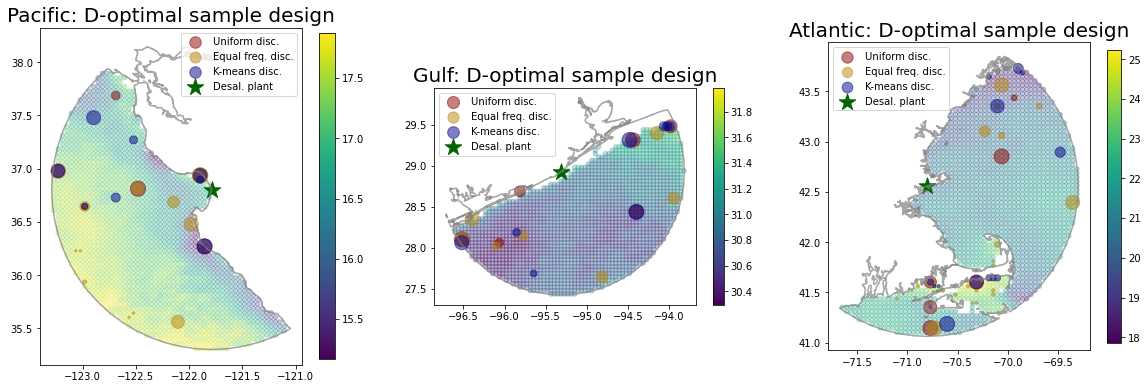

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(20,20))

# PAC
PAC[1].boundary.plot(ax=ax[0], alpha=0.7, color='gray') # background
PAC[0].plot(ax=ax[0], column='max_t', alpha=0.3, markersize=20, legend=True, legend_kwds={'shrink': 0.3})
PAC[3].plot(ax=ax[0], color='darkred', markersize=PAC[3].n_samples*5, alpha=0.5, label='Uniform disc.') # sample points
PAC[4].plot(ax=ax[0], color='darkgoldenrod', markersize=PAC[4].n_samples*5, alpha=0.5, label='Equal freq. disc.') # sample points
PAC[5].plot(ax=ax[0], color='darkblue', markersize=PAC[5].n_samples*5, alpha=0.5, label='K-means disc.') # sample points
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[0], color='darkgreen', markersize=300, marker='*', label='Desal. plant') # desalination plant
ax[0].set_title(f'Pacific: D-optimal sample design') #title
ax[0].legend()
# GUL
GUL[1].boundary.plot(ax=ax[1], alpha=0.7, color='gray') # background
GUL[0].plot(ax=ax[1], column='max_t', alpha=0.3, markersize=20, legend=True, legend_kwds={'shrink': 0.2})
GUL[3].plot(ax=ax[1], color='darkred', markersize=GUL[3].n_samples*5, alpha=0.5, label='Uniform disc.') # sample points
GUL[4].plot(ax=ax[1], color='darkgoldenrod', markersize=GUL[4].n_samples*5, alpha=0.5, label='Equal freq. disc.') # sample points
GUL[5].plot(ax=ax[1], color='darkblue', markersize=GUL[5].n_samples*5, alpha=0.5, label='K-means disc.') # sample points
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[1], color='darkgreen', markersize=300, marker='*', label='Desal. plant') # desalination plant
ax[1].set_title(f'Gulf: D-optimal sample design') #title
ax[1].legend()

# ATL
ATL[1].boundary.plot(ax=ax[2], alpha=0.7, color='gray') # background
ATL[0].plot(ax=ax[2], column='max_t', alpha=0.3, markersize=20, legend=True, legend_kwds={'shrink': 0.27})
ATL[3].plot(ax=ax[2], color='darkred', markersize=ATL[3].n_samples*5, alpha=0.5, label='Uniform disc.') # sample points
ATL[4].plot(ax=ax[2], color='darkgoldenrod', markersize=ATL[4].n_samples*5, alpha=0.5, label='Equal freq. disc.') # sample points
ATL[5].plot(ax=ax[2], color='darkblue', markersize=ATL[5].n_samples*5, alpha=0.5, label='K-means disc.') # sample points
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[2], color='darkgreen', markersize=300, marker='*', label='Desal. plant') # desalination plant
ax[2].set_title(f'Atlantic: D-optimal sample design') #title
ax[2].legend()

plt.show()

# Run regressions

In [ ]:
CLUSTERS=5
estimator = LinearRegression()
params = {}

grid_search = GridSearchCV(estimator, param_grid=params, scoring='neg_root_mean_squared_error', cv=GroupKFold(n_splits=CLUSTERS))

CLUSTERS = 10
cl = cluster.KMeans(n_clusters=CLUSTERS)
cl.fit(m_sub.loc[m_sub.pacific, ['x', 'y']])
X_pac['kmeans_cluster'] = cl.labels_
cl.fit(m_sub.loc[m_sub.pacific==False,['x', 'y']])
X_atl['kmeans_cluster'] = cl.labels_


cv = grid_search.fit(df[predictor_vars], df[response_var], groups=df['kmeans_cluster'])

x_in = X.loc[:, ('pacific', 'month', 'year', 'chlor_a_cln', 'sst_cln', 'months_below_mean', 'max', 'std', 'max_ca', 'std_ca')]

grid_search = GridSearchCV(\n",
    "            estimator=estimator, \n",
    "            param_grid=params,\n",
    "            scoring=scoring,\n",
    "            refit=False, \n",
    "            cv=GroupKFold(n_splits=CLUSTERS), \n",
    "            verbose=0, \n",
    "            return_train_score=False\n",
    ")\n",
    "\n",
    "cv_summ = pd.DataFrame()\n",
    "for ocean in [True, False]:\n",
    "    \n",
    "    df = m_sub.loc[m_sub.pacific==ocean]\n",
    "    cl.fit(df[['x', 'y']])\n",
    "    df['kmeans_cluster'] = cl.labels_\n",
    "    \n",
    "    cv = grid_search.fit(df[predictor_vars], df[response_var], groups=df['kmeans_cluster'])\n",
    "\n",
    "    cv = pd.DataFrame({'pacific': [ocean]*len(cv.cv_results_['params']),\n",
    "        'model': [str(estimator)]*len(cv.cv_results_['params']),\n",
    "        'params': cv.cv_results_['params'],\n",
    "        'mean_test_neg_mean_squared_error': cv.cv_results_['mean_test_neg_mean_squared_error'],\n",
    "        'mean_test_r_squared': cv.cv_results_['mean_test_r_squared']}).sort_values('mean_test_neg_mean_squared_error')\n",
    "    cv_summ = pd.concat([cv, cv_summ])\n",

In [14]:
?GridSearchCV

Init signature:
GridSearchCV(
    estimator,
    param_grid,
    *,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
)
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "score_samples", "predict", "predict_proba",
"decision_function", "transform" and "inverse_transform" if they are
implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or list of